# Word2Vec Under the hood


word2vec이 어떤게 구현되는지 알아보자. 

## References

이론

* [BEOMSU KIM /word2vec 관련 이론 정리](https://shuuki4.wordpress.com/2016/01/27/word2vec-%EA%B4%80%EB%A0%A8-%EC%9D%B4%EB%A1%A0-%EC%A0%95%EB%A6%AC/)

코드

* [Minsuk Heo 허민석](https://www.youtube.com/channel/UCxP77kNgVfiiG6CXZ5WMuAQ)
  - [딥러닝 자연어처리 Word2Vec](https://www.youtube.com/watch?v=sY4YyacSsLc)
  - [python_tutorial/data_science/nlp/word2vec_tensorflow.ipynb](https://github.com/minsuk-heo/python_tutorial/blob/master/data_science/nlp/word2vec_tensorflow.ipynb)★
  
* tensorflow tutorial
  - [representation/word2vec](https://www.tensorflow.org/tutorials/representation/word2vec)
  - [representation/word2vec 한글판](https://tensorflowkorea.gitbooks.io/tensorflow-kr/g3doc/tutorials/word2vec/)
  - [tensorflow/models/tutorials/embedding](https://github.com/tensorflow/models/tree/master/tutorials/embedding)


## Input Data 준비하기

In [1]:
raw_corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

WINDOW_SIZE = 2

In [2]:
def remove_stop_words( line, stop_words_list ):
    tmp = [ word for word in line.split() if word not in stop_words_list ]
    return " ".join( tmp )


In [3]:
from collections import Counter

def get_dicts( corpus ):
    words = ( " ".join( corpus ) ).split()
    cnt = Counter( words )
    dic = list( cnt.keys() )
    return {
        'cnt': cnt,
        'dic': dic,
        'dic2idx': dict( [ (w, i) for i, w in enumerate( dic ) ] ),
        'frq': list( cnt.values() ),
        'size': len( dic )
    }

In [4]:
def get_skip_gram( corpus, window_size ):
    rst = []
    for line in corpus:
        words = line.split()
        line_size = len( words )
        for i, w in enumerate( words  ):
            left_lim = max( i - window_size, 0 )
            right_lim = min( i + window_size, line_size ) + 1
            neighbors = words[ left_lim:right_lim ]
            for neighbor in neighbors:
                if w != neighbor : rst.append( ( w, neighbor) )
    return rst


In [5]:
stop_words_list = ['is', 'a', 'will', 'be']
corpus = [ remove_stop_words( line, stop_words_list ) for line in raw_corpus ]
dicts = get_dicts( corpus )
skip_grams = get_skip_gram( corpus, WINDOW_SIZE )
print(skip_grams)

[('king', 'strong'), ('king', 'man'), ('strong', 'king'), ('strong', 'man'), ('man', 'king'), ('man', 'strong'), ('queen', 'wise'), ('queen', 'woman'), ('wise', 'queen'), ('wise', 'woman'), ('woman', 'queen'), ('woman', 'wise'), ('boy', 'young'), ('boy', 'man'), ('young', 'boy'), ('young', 'man'), ('man', 'boy'), ('man', 'young'), ('girl', 'young'), ('girl', 'woman'), ('young', 'girl'), ('young', 'woman'), ('woman', 'girl'), ('woman', 'young'), ('prince', 'young'), ('prince', 'king'), ('young', 'prince'), ('young', 'king'), ('king', 'prince'), ('king', 'young'), ('princess', 'young'), ('princess', 'queen'), ('young', 'princess'), ('young', 'queen'), ('queen', 'princess'), ('queen', 'young'), ('man', 'strong'), ('strong', 'man'), ('woman', 'pretty'), ('pretty', 'woman'), ('prince', 'boy'), ('prince', 'king'), ('boy', 'prince'), ('boy', 'king'), ('king', 'prince'), ('king', 'boy'), ('princess', 'girl'), ('princess', 'queen'), ('girl', 'princess'), ('girl', 'queen'), ('queen', 'princess')

## 학습 준비하기

In [6]:
import numpy as np

def to_one_hot( idx, dim ):
    one_hot = np.zeros( dim )
    one_hot[ idx ] = 1
    return one_hot



In [7]:
X, Y = [], []
for x, y in skip_grams:
    X.append( dicts.get('dic2idx')[ x ] )
    Y.append( [ dicts.get('dic2idx')[ y ] ] )


### Define Tensor Graph 

In [8]:
import tensorflow as tf
import math 

In [9]:
EMBEDDING_DIM = 2
LEARNING_RATE = 0.05
EPOCHS = 20001

X_train = np.asarray(X)
Y_train = np.asarray(Y)

In [10]:
embedding_size = EMBEDDING_DIM
vocabulary_size = dicts.get('size')
num_sampled = 4  # Number of negative examples to sample.

![](https://i.stack.imgur.com/447Nn.png)

* input layer : `train_inputs` _(id of target words)_
  - W : `embeddings`
* hidden layer : `embed`
  - W\` : `nce_weights`
* output ayer : `y_ = tf.matmul(embed, tf.transpose(nce_weights)) + nce_biases`
  - `train_labels` _(id of target words)_

※ [ref](https://stackoverflow.com/questions/41475180/understanding-tf-nn-nce-loss-in-tensorflow)

In [11]:
# Placeholders for inputs
## train_inputs consists of some int32 number, representing the id of target words
train_inputs = tf.placeholder( tf.int32, shape=[None] )
train_labels = tf.placeholder( tf.int32, shape=[None, 1] )

# embeddings
embeddings = tf.Variable( tf.random_uniform( [vocabulary_size, embedding_size], -1.0, 1.0 ) )
embed = tf.nn.embedding_lookup( embeddings, train_inputs )

# noise-contrastive estimation loss
nce_weights = tf.Variable( tf.truncated_normal( [vocabulary_size, embedding_size], stddev=1.0 / math.sqrt( embedding_size ) ) )
nce_biases = tf.Variable( tf.zeros( [vocabulary_size] ) )

In [12]:
# 매번 음수 라벨링 된 셈플을 이용한 NCE(noise-contrastive estimation) loss 계산
loss = tf.reduce_mean( 
    tf.nn.nce_loss( 
        inputs=embed,               # [batch_size, embed_size]
        labels=train_labels,        # [batch_size, 1]
        weights=nce_weights,        # [vocab_size, embed_size]
        biases=nce_biases,          # [embed_size]
        num_sampled=num_sampled,
        num_classes=vocabulary_size ) )

# SGD optimizer 를 사용
optimizer = tf.train.GradientDescentOptimizer( learning_rate=0.01 ).minimize( loss )

norm = tf.sqrt( tf.reduce_sum( tf.square( embeddings ), 1, keepdims=True ) )
final_embeddings = normalized_embeddings = embeddings / norm

### Train

In [13]:
sess = tf.Session()
sess.run( tf.global_variables_initializer() )

feed_dict = { train_inputs: X_train, train_labels: Y_train }

for i in range( EPOCHS ):
    sess.run( optimizer, feed_dict=feed_dict )
    if i % 2000 == 0 :
        print( "Epochs " + str(i) + " / Loss is : ", sess.run( loss, feed_dict=feed_dict ) )


Epochs 0 / Loss is :  5.7753296
Epochs 2000 / Loss is :  2.0055728
Epochs 4000 / Loss is :  2.075962
Epochs 6000 / Loss is :  2.1787121
Epochs 8000 / Loss is :  1.9633803
Epochs 10000 / Loss is :  1.7637076
Epochs 12000 / Loss is :  1.6726067
Epochs 14000 / Loss is :  1.9603559
Epochs 16000 / Loss is :  1.7754942
Epochs 18000 / Loss is :  1.9173257
Epochs 20000 / Loss is :  1.8473862


## Word2Vec 도출

In [14]:
vectors =  sess.run( final_embeddings, feed_dict=feed_dict )
print( vectors )

[[ 0.99465007 -0.10330188]
 [ 0.96688765 -0.2552023 ]
 [ 0.9731148  -0.23032069]
 [-0.06144837  0.9981103 ]
 [ 0.08075175  0.99673426]
 [ 0.09077037  0.9958718 ]
 [ 0.9897472  -0.1428296 ]
 [ 0.59622073  0.80282056]
 [ 0.07657274  0.997064  ]
 [ 0.9671703  -0.2541289 ]
 [ 0.34087497  0.94010866]
 [-0.11841833  0.9929638 ]]


### DataFrame으로 표현

In [15]:
import pandas as pd
w2v_df = pd.DataFrame( vectors, columns=['x1', 'x2'] )
w2v_df['word'] = dicts.get("dic")
w2v_df = w2v_df[ [ 'word', 'x1', 'x2' ] ] 
w2v_df

,word,x1,x2
0,king,0.994650,-0.103302
1,strong,0.966888,-0.255202
2,man,0.973115,-0.230321
3,queen,-0.061448,0.998110
4,wise,0.080752,0.996734
5,woman,0.090770,0.995872
6,boy,0.989747,-0.142830
7,young,0.596221,0.802821
8,girl,0.076573,0.997064
9,prince,0.967170,-0.254129


### Plot으로 표현

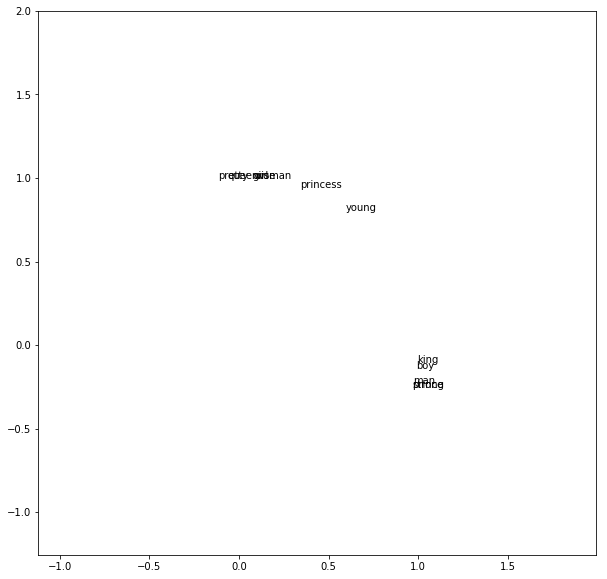

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip( w2v_df['word'], w2v_df['x1'], w2v_df['x2'] ):
    ax.annotate( word, ( x1, x2 ) )

PADDING = 1.0
x_axis_min = np.amin( vectors, axis=0)[0] - PADDING
x_axis_max = np.amax( vectors, axis=0)[0] + PADDING
y_axis_min = np.amin( vectors, axis=0)[1] - PADDING
y_axis_max = np.amax( vectors, axis=0)[1] + PADDING

plt.xlim( x_axis_min, x_axis_max )
plt.ylim( y_axis_min, y_axis_max )
plt.rcParams['figure.figsize'] = (10, 10)

plt.show()